### Redes Neurais e Aprendizado Profundo
#### **MBA em Ciências de Dados**

### *Módulo 4 - Treinamento de Redes Profundas*

**Regularização e Normalização**

Moacir Antonelli Ponti

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from numpy.random import seed
from tensorflow.random import set_seed

tfds.disable_progress_bar()

Carregando a base de dados "Cats vs Dogs"

Vamos ainda re-dimensionar as imagens para o tamanho $150\times 150$

Posteriormente, para aumentar a velocidade, vamos pré-calcular os batches

In [2]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[0%:20%]", "train[20%:25%]", "train[25%:40%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul,

In [3]:
# definindo tamanho de batch e colocando os batches num "cache"
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

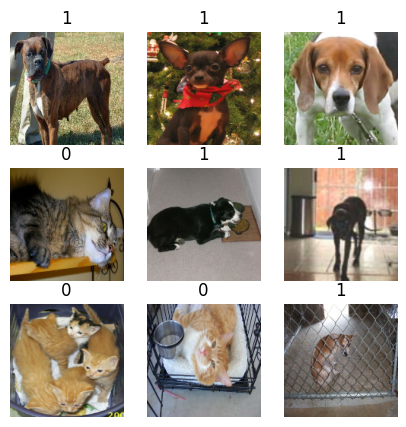

In [4]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

### 1) Vamos investigar uma CNN sequencial, e adicionar opções de Dropout (regularização), e normalização por batch e por camada

In [5]:
def my_cnn(input_shape, num_classes, dropout_rate=0.0, batch_norm=False, layer_norm=False):

    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)

    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    # guarda ativacao para somar ao fim do bloco residual
    ativacao_residual = x

    for n_filtros in [64,64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(n_filtros, 1, strides=2, padding="same")(
            ativacao_residual
        )
        x = layers.add([x, residual])  # adiciona resisual
        ativacao_residual = x  # armazena saida do bloco

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        neuronios = 1
    else:
        activation = "softmax"
        neuronios = num_classes

    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(neuronios, activation=activation)(x)

    return keras.Model(inputs, outputs)

### I - Avaliando o papel da Normalização

In [6]:
seed(1)
set_seed(2)

epochs = 8

CNN1 = my_cnn(input_shape=input_shape, num_classes=2,
              dropout_rate=0.0, batch_norm=False, layer_norm=False)
CNN1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              metrics=['accuracy'])

hist1 = CNN1.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
146/146 [==============================] - 30s 85ms/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 0.6925 - val_accuracy: 0.5189
Epoch 2/8
146/146 [==============================] - 5s 34ms/step - loss: 0.6926 - accuracy: 0.5138 - val_loss: 0.6916 - val_accuracy: 0.5309
Epoch 3/8
146/146 [==============================] - 5s 34ms/step - loss: 0.6919 - accuracy: 0.5277 - val_loss: 0.6901 - val_accuracy: 0.5619
Epoch 4/8
146/146 [==============================] - 5s 35ms/step - loss: 0.6905 - accuracy: 0.5464 - val_loss: 0.6874 - val_accuracy: 0.5610
Epoch 5/8
146/146 [==============================] - 5s 33ms/step - loss: 0.6879 - accuracy: 0.5486 - val_loss: 0.6829 - val_accuracy: 0.5662
Epoch 6/8
146/146 [==============================] - 5s 34ms/step - loss: 0.6841 - accuracy: 0.5540 - val_loss: 0.6772 - val_accuracy: 0.5722
Epoch 7/8
146/146 [==============================] - 5s 33ms/step - loss: 0.6799 - accuracy: 0.5621 - val_loss: 0.6718 - val_accuracy: 0.5739
Epoch

### com Batch Normalization

In [7]:
seed(1)
set_seed(2)

CNN2 = my_cnn(input_shape=input_shape, num_classes=2,
              dropout_rate=0.0, batch_norm=True, layer_norm=False)

CNN2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              metrics=['accuracy'])

hist2 = CNN2.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
146/146 [==============================] - 13s 46ms/step - loss: 0.6573 - accuracy: 0.5989 - val_loss: 0.7110 - val_accuracy: 0.4905
Epoch 2/8
146/146 [==============================] - 6s 42ms/step - loss: 0.6238 - accuracy: 0.6481 - val_loss: 0.8381 - val_accuracy: 0.4905
Epoch 3/8
146/146 [==============================] - 6s 43ms/step - loss: 0.5999 - accuracy: 0.6756 - val_loss: 1.1213 - val_accuracy: 0.4905
Epoch 4/8
146/146 [==============================] - 6s 42ms/step - loss: 0.5781 - accuracy: 0.7021 - val_loss: 0.9012 - val_accuracy: 0.5198
Epoch 5/8
146/146 [==============================] - 6s 42ms/step - loss: 0.5612 - accuracy: 0.7165 - val_loss: 0.5776 - val_accuracy: 0.6838
Epoch 6/8
146/146 [==============================] - 6s 42ms/step - loss: 0.5477 - accuracy: 0.7257 - val_loss: 0.6057 - val_accuracy: 0.6864
Epoch 7/8
146/146 [==============================] - 7s 48ms/step - loss: 0.5365 - accuracy: 0.7311 - val_loss: 0.6271 - val_accuracy: 0.6770
Epoch

### com Layer Normalization

In [8]:
seed(1)
set_seed(2)

CNN3 = my_cnn(input_shape=input_shape, num_classes=2,
              dropout_rate=0.0, batch_norm=False, layer_norm=True)

CNN3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              metrics=['accuracy'])

hist3 = CNN3.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
146/146 [==============================] - 25s 120ms/step - loss: 0.6913 - accuracy: 0.5303 - val_loss: 0.6750 - val_accuracy: 0.5954
Epoch 2/8
146/146 [==============================] - 15s 105ms/step - loss: 0.6697 - accuracy: 0.5873 - val_loss: 0.6422 - val_accuracy: 0.6177
Epoch 3/8
146/146 [==============================] - 15s 106ms/step - loss: 0.6536 - accuracy: 0.6083 - val_loss: 0.6285 - val_accuracy: 0.6237
Epoch 4/8
146/146 [==============================] - 15s 106ms/step - loss: 0.6432 - accuracy: 0.6197 - val_loss: 0.6188 - val_accuracy: 0.6263
Epoch 5/8
146/146 [==============================] - 15s 104ms/step - loss: 0.6337 - accuracy: 0.6290 - val_loss: 0.6101 - val_accuracy: 0.6418
Epoch 6/8
146/146 [==============================] - 15s 104ms/step - loss: 0.6242 - accuracy: 0.6455 - val_loss: 0.6002 - val_accuracy: 0.6529
Epoch 7/8
146/146 [==============================] - 16s 112ms/step - loss: 0.6144 - accuracy: 0.6617 - val_loss: 0.5899 - val_accuracy:

com BN + Regularização Dropout

In [9]:
seed(1)
set_seed(2)

CNN4 = my_cnn(input_shape=input_shape, num_classes=2,
              dropout_rate=0.25, batch_norm=True)

CNN4.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              metrics=['accuracy'])

hist4 = CNN4.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
146/146 [==============================] - 13s 43ms/step - loss: 0.6821 - accuracy: 0.5858 - val_loss: 0.6959 - val_accuracy: 0.4905
Epoch 2/8
146/146 [==============================] - 6s 43ms/step - loss: 0.6400 - accuracy: 0.6232 - val_loss: 0.7382 - val_accuracy: 0.4905
Epoch 3/8
146/146 [==============================] - 6s 42ms/step - loss: 0.6269 - accuracy: 0.6460 - val_loss: 0.8436 - val_accuracy: 0.4905
Epoch 4/8
146/146 [==============================] - 6s 43ms/step - loss: 0.6029 - accuracy: 0.6694 - val_loss: 0.6690 - val_accuracy: 0.5928
Epoch 5/8
146/146 [==============================] - 6s 42ms/step - loss: 0.5869 - accuracy: 0.6872 - val_loss: 0.6040 - val_accuracy: 0.6546
Epoch 6/8
146/146 [==============================] - 6s 43ms/step - loss: 0.5705 - accuracy: 0.6948 - val_loss: 0.6900 - val_accuracy: 0.6375
Epoch 7/8
146/146 [==============================] - 6s 41ms/step - loss: 0.5565 - accuracy: 0.7130 - val_loss: 0.6671 - val_accuracy: 0.6478
Epoch

In [10]:
scores1 = CNN1.evaluate(validation_ds, verbose=0)
scores2 = CNN2.evaluate(validation_ds, verbose=0)
scores3 = CNN3.evaluate(validation_ds, verbose=0)
scores4 = CNN4.evaluate(validation_ds, verbose=0)

In [11]:
print("Na validação")
print("BatchNorm LayerNorm Dropout - Loss\tAcc")
print("    -         -        -      %.4f\t%.4f" % (scores1[0],scores1[1]))
print("    X         -        -      %.4f\t%.4f" % (scores2[0],scores2[1]))
print("    -         X        -      %.4f\t%.4f" % (scores3[0],scores3[1]))
print("    X         -        X      %.4f\t%.4f" % (scores4[0],scores4[1]))

Na validação
BatchNorm LayerNorm Dropout - Loss	Acc
    -         -        -      0.6669	0.5773
    X         -        -      0.6274	0.6796
    -         X        -      0.5811	0.6796
    X         -        X      0.6657	0.6546


**Resumo: avaliando os modelos agora no teste**

In [12]:
scores1 = CNN1.evaluate(test_ds, verbose=0)
scores2 = CNN2.evaluate(test_ds, verbose=0)
scores3 = CNN3.evaluate(test_ds, verbose=0)
scores4 = CNN4.evaluate(test_ds, verbose=0)

In [13]:
print("BatchNorm LayerNorm Dropout - Loss\tAcc")
print("    -         -        -      %.4f\t%.4f" % (scores1[0],scores1[1]))
print("    X         -        -      %.4f\t%.4f" % (scores2[0],scores2[1]))
print("    -         X        -      %.4f\t%.4f" % (scores3[0],scores3[1]))
print("    X         -        X      %.4f\t%.4f" % (scores4[0],scores4[1]))

BatchNorm LayerNorm Dropout - Loss	Acc
    -         -        -      0.6704	0.5744
    X         -        -      0.6127	0.6756
    -         X        -      0.5704	0.7085
    X         -        X      0.6639	0.6489
